# Support Vector Regression

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df1 = pd.read_csv("../data/df1.csv", index_col=0)

In [16]:
df1.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left_binned,duration_sqrt_scaled,price_boxcox_scaled
0,-0.518731,-0.068017,0.026656,-0.27363,0.015281,0.009063,-0.577809,0.437431,-1.735912,-0.498010
1,-0.518731,-0.068017,-0.026516,-0.27363,0.061629,0.009063,-0.577809,0.437431,-1.685797,-0.498010
2,-0.713457,-0.068017,-0.026516,-0.27363,-0.156916,0.009063,-0.577809,0.437431,-1.735912,-0.497464
3,0.309109,-0.068017,0.005012,-0.27363,-0.047256,0.009063,-0.577809,0.437431,-1.710632,-0.497646
4,0.309109,-0.068017,0.005012,-0.27363,0.061629,0.009063,-0.577809,0.437431,-1.685797,-0.497646


### Identifying Correlation

Determining the correlation between features to identify the most correlated one across the board as the dependent variable.

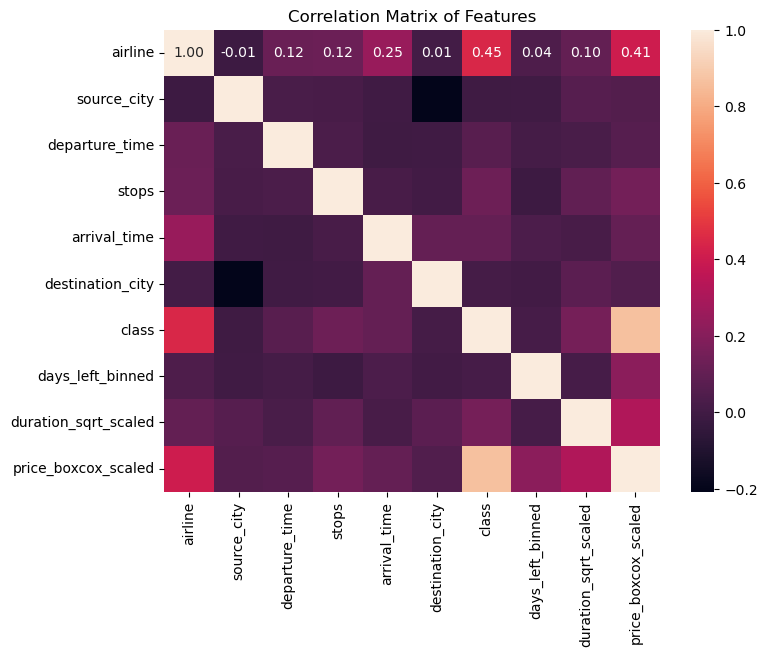

In [17]:
correlation_matrix = df1.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

From the graph, we can determine that price_boxcox_scaled is the most correlated with other variables. Thus, it will be used as the dependent variable.

### Train Test Split

In [18]:
X = df1[['airline', 'source_city',	'departure_time', 'stops', 'arrival_time', 'destination_city', 
      'class', 'days_left_binned', 'duration_sqrt_scaled']]
y = df1['price_boxcox_scaled']

We will divide the dataset into Train:Test ratio of 0.8:0.2.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<i>Question: Should I include validation set?</i>

### Regularization *

<i>Question: Do I need to regularise the data? Or has it already been done so in pre-processing stages?</i>

### Ordinary Least Squares

Performing OLS check to determine the significant independent variables for the model.

In [20]:
X_train_const = sm.add_constant(X_train)

ols_model = sm.OLS(y_train, X_train_const)
ols_results = ols_model.fit()

In [21]:
ols_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:              OLS                 Adj. R-squared:     0.825      
Dependent Variable: price_boxcox_scaled AIC:                260416.4277
Date:               2024-02-29 10:59    BIC:                260520.2288
No. Observations:   238021              Log-Likelihood:     -1.3020e+05
Df Model:           9                   F-statistic:        1.247e+05  
Df Residuals:       238011              Prob (F-statistic): 0.00       
R-squared:          0.825               Scale:              0.17485    
-----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
const                   0.0055   0.0009   6.4411 0.0000  0.0038  0.0072
airline                 0.0226   0.0025   9.1905 0.0000  0.0177  0.0274
source_city             1.0292   0.0161  63.8065 0.0000  0.9976  1.0608
departure_time         -0.0544   0.0138  -3.9513 0.0001 -0.0814 -0.0274
stops                   0.1581   0.0059  26.6271 0.0000  0.1464  0.1697
arrival_time           -0.0027   0.0086  -0.3103 0.7563 -0.0194  0.0141
destination_city        0.7667   0.0176  43.5654 0.0000  0.7322  0.8012
class                   0.9566   0.0011 854.4979 0.0000  0.9544  0.9588
days_left_binned        0.9124   0.0040 228.4625 0.0000  0.9046  0.9203
duration_sqrt_scaled    0.1774   0.0009 202.1697 0.0000  0.1757  0.1791
-----------------------------------------------------------------------
Omnibus:              10479.711       Durbin-Watson:          2.006    
Prob(Omnibus):        0.000           Jarque-Bera (JB):       31706.578
Skew:                 -0.158          Prob(JB):               0.000    
Kurtosis:             4.760           Condition No.:          23       
=======================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

From here, we can determine that arrival_time is not significant. And we will remove it from the independent variables.

In [22]:
new_X_train = X_train[['airline', 'source_city', 'departure_time', 'stops',
       'destination_city', 'class', 'days_left_binned','duration_sqrt_scaled']]
new_X_test = X_test[['airline', 'source_city', 'departure_time', 'stops',
       'destination_city', 'class', 'days_left_binned','duration_sqrt_scaled']]

In [23]:
new_X_train_const = sm.add_constant(new_X_train)

new_ols_model = sm.OLS(y_train, new_X_train_const)
new_ols_results = new_ols_model.fit()

In [24]:
new_ols_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:              OLS                 Adj. R-squared:     0.825      
Dependent Variable: price_boxcox_scaled AIC:                260414.5240
Date:               2024-02-29 10:59    BIC:                260507.9450
No. Observations:   238021              Log-Likelihood:     -1.3020e+05
Df Model:           8                   F-statistic:        1.402e+05  
Df Residuals:       238012              Prob (F-statistic): 0.00       
R-squared:          0.825               Scale:              0.17485    
-----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
const                   0.0055   0.0009   6.4455 0.0000  0.0039  0.0072
airline                 0.0224   0.0024   9.3785 0.0000  0.0177  0.0270
source_city             1.0291   0.0161  63.8183 0.0000  0.9975  1.0607
departure_time         -0.0542   0.0138  -3.9419 0.0001 -0.0812 -0.0273
stops                   0.1581   0.0059  26.6292 0.0000  0.1465  0.1697
destination_city        0.7661   0.0175  43.7995 0.0000  0.7318  0.8003
class                   0.9566   0.0011 854.5218 0.0000  0.9544  0.9588
days_left_binned        0.9124   0.0040 228.5482 0.0000  0.9046  0.9202
duration_sqrt_scaled    0.1774   0.0009 202.1946 0.0000  0.1757  0.1791
-----------------------------------------------------------------------
Omnibus:              10480.100       Durbin-Watson:          2.006    
Prob(Omnibus):        0.000           Jarque-Bera (JB):       31706.330
Skew:                 -0.158          Prob(JB):               0.000    
Kurtosis:             4.760           Condition No.:          22       
=======================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

No visible improvement in R2 or Adj. R2 Scores. However, they are still quite high, and are identical. Implying that there is no substantial overfitting from the independent variables used.

### Variance Inflation Factor:

In [25]:
new_X_range = len(new_X_train_const.columns)

for i in range(1, new_X_range):
    v = vif(new_X_train_const.values, i)
    print("VIF for {}: {}".format(new_X_train_const.columns[i], round(v, 4)))

VIF for airline: 1.2699
VIF for source_city: 1.0543
VIF for departure_time: 1.0158
VIF for stops: 1.0294
VIF for destination_city: 1.0544
VIF for class: 1.2733
VIF for days_left_binned: 1.0022
VIF for duration_sqrt_scaled: 1.045


All independent variables' VIF are small, and below 10. Thus, there is no multicolinearity among them.

### SVR Modelling

Training the model with pre-determined parameters.

In [26]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

Estimated run time for model fitting: 100-130 mins.

In [27]:
svr_rbf.fit(new_X_train, y_train)
    
y_pred = svr_rbf.predict(new_X_test)

In [30]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [31]:
print("Mean Absolute Error: " + str(mae))
print("Mean Squared Error: " + str(mse))
print("Root Mean Squared Error: " + str(rmse))
print("R2 Score: " + str(r2))

Mean Absolute Error: 0.24251893199215085
Mean Squared Error: 0.13413369675532666
Root Meam Squared Error: 0.3662426746780428
R2 Score: 0.8659482932966688


Inferences: <br>
<ul>
    <li>The current model explains about 86.63% of the variance in the dependent variable price_boxcox_scaled. (R2)</li>
    <li>The model's predictions are 0.2435 units from the actual values on average. (MAE)</li>
    <li>The average of the squares of the errors between the predicted and actual values is about 0.1337 units.</li>
    <li>The intepretable, actual average of the errors between the predicted and actual values is about 0.3657 units.</li>
</ul>

Reinforcing the values with the Mean Absolute Percentage Error:

In [ ]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error: " + str(mape))

For comparison, we fit the model with the inclusion of the insignificant independent variable removed earlier.

In [ ]:
svr_rbf.fit(X_train, y_train)
    
old_y_pred = svr_rbf.predict(X_test)

In [ ]:
old_mae = mean_absolute_error(y_test, old_y_pred)
old_mse = mean_squared_error(y_test, old_y_pred)
old_rmse = np.sqrt(mse)
old_r2 = r2_score(y_test, old_y_pred)

In [ ]:
print("Mean Absolute Error: " + str(old_mae))
print("Mean Squared Error: " + str(old_mse))
print("Root Mean Squared Error: " + str(old_rmse))
print("R2 Score: " + str(old_r2))

Mean Absolute Error: 0.2434806249370293
Mean Squared Error: 0.13371570839006203
Root Meam Squared Error: 0.3656715854288682
R2 Score: 0.866260291096647


Compared to the optimized feature selection iteration, the older version is only slightly worse with a barely noticable difference.

<i>Since this is regression, would I need to prove any assumptions for the function generated from the model. E.g.: Linear Regression's linearity, equal variance, independence & normal assumptions.</i>

### Function Parameter Extraction

In [32]:
# Extract support vectors
support_vectors = svr_rbf.support_vectors_

# Extract dual coefficients (Lagrange multipliers)
dual_coef = svr_rbf.dual_coef_

# Extract intercept
intercept = svr_rbf.intercept_

# Extract kernel parameters
kernel_params = svr_rbf.get_params()

In [34]:
print("Support Vectors:", support_vectors)
print("Dual Coefficients:", dual_coef)
print("Intercept:", intercept[0])
print("Kernel Parameters:", kernel_params)

Support Vectors: [[ 1.96030109e-01  1.08809170e-03  2.66563465e-02 ... -5.77808533e-01
   3.41153712e-01 -9.32645169e-01]
 [-5.80606895e-01 -3.76553557e-02 -9.12784604e-02 ... -5.77808533e-01
  -1.40010249e-01  2.67524804e-01]
 [ 3.09109372e-01  2.01016521e-02  2.66563465e-02 ...  1.29438733e+00
  -1.40010249e-01  6.18090083e-01]
 ...
 [-5.80606895e-01 -3.76553557e-02 -2.65159973e-02 ... -5.77808533e-01
  -1.71592752e-01 -9.83684160e-01]
 [ 3.09109372e-01 -6.80173865e-02 -9.12784604e-02 ...  1.29438733e+00
  -4.65249132e-02  3.12892629e-02]
 [-5.80606895e-01  1.05036766e-01  5.01235685e-03 ... -5.77808533e-01
  -1.71592752e-01 -7.55611008e-02]]
Dual Coefficients: [[-100.  100.  100. ...  100. -100. -100.]]
Intercept: 9.075440402938002
Kernel Parameters: {'C': 100, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


From the results, we can idenfity that the intercept is 9.075440402938002. <br>
The kernel parameters used are as such:
<ul>
    <li>C (Hyperparameter): 100</li>
    <li>Cache Size: 200</li>
    <li>Coefficient 0: 0</li>
    <li>Degree: 3</li>
    <li>Epsilon size: 0.1</li>
    <li>Gamma: 0.1</li>
    <li>Kernel used: Radial Basis Function (RBF)</li>
    <li>Maximum iterations: -1</li>
    <li>Shrinking: True</li>
    <li>Tolerance for convergence (tol): 0.001</li>
    <li>Verbose: False</li>
</ul>

In [69]:
support_vectors_df = pd.DataFrame(support_vectors, columns=['sv_airline', 'sv_source_city', 'sv_departure_time', 'sv_stops',
                                                            'sv_destination_city', 'sv_class', 'sv_days_left_binned',
                                                            'sv_duration_sqrt_scaled'])

dual_coef_df = pd.DataFrame({'dual_coef': dual_coef[0]})

svr_measurements = pd.concat([support_vectors_df, dual_coef_df], axis=1)

In [72]:
svr_measurements.head()

,sv_airline,sv_source_city,sv_departure_time,sv_stops,sv_destination_city,sv_class,sv_days_left_binned,sv_duration_sqrt_scaled,dual_coef
0,0.196030,0.001088,0.026656,0.061277,0.073433,-0.577809,0.341154,-0.932645,-100.0
1,-0.580607,-0.037655,-0.091278,-0.273630,-0.078687,-0.577809,-0.140010,0.267525,100.0
2,0.309109,0.020102,0.026656,0.061277,0.009063,1.294387,-0.140010,0.618090,100.0
3,0.309109,-0.021865,0.086165,0.061277,0.025301,-0.577809,-0.171593,-2.103655,-100.0
4,-0.713457,-0.068017,-0.026516,0.061277,0.025301,-0.577809,-0.140010,-0.434495,-100.0


### Predictor

In [2]:
measurements_dataset = pd.read_csv("../data/svr_results/svr_measurements.csv", index_col=0)
measurements_df = pd.DataFrame(measurements_dataset)
measurements_df.head()

,sv_airline,sv_source_city,sv_departure_time,sv_stops,sv_destination_city,sv_class,sv_days_left_binned,sv_duration_sqrt_scaled,dual_coef
0,0.196030,0.001088,0.026656,0.061277,0.073433,-0.577809,0.341154,-0.932645,-100.0
1,-0.580607,-0.037655,-0.091278,-0.273630,-0.078687,-0.577809,-0.140010,0.267525,100.0
2,0.309109,0.020102,0.026656,0.061277,0.009063,1.294387,-0.140010,0.618090,100.0
3,0.309109,-0.021865,0.086165,0.061277,0.025301,-0.577809,-0.171593,-2.103655,-100.0
4,-0.713457,-0.068017,-0.026516,0.061277,0.025301,-0.577809,-0.140010,-0.434495,-100.0


In [6]:
sv = measurements_df.iloc[:,:8]
dc = measurements_df[['dual_coef']]

In [75]:
svr_measurements.to_csv("../data/svr_results/svr_measurements.csv")

In [10]:
def svr_predictor(x):
    # Initialize predicted values
    y_pred = 0
    
    # Compute the contribution of each support vector to the prediction
    for i in range(measurements_df.shape[0]):
        # Compute the kernel function between the input x and the ith support vector
        kernel_value = kernel_function(x, sv.loc[i])
        
        # Multiply the kernel value by the dual coefficient and add it to the prediction
        y_pred += measurements_df.loc[i] * kernel_value
    
    # Add the intercept term to the prediction
    y_pred += intercept
    
    return y_pred

def kernel_function(x1, x2):
    # Example: Radial Basis Function (RBF) kernel
    gamma = 0.1  # Example gamma parameter
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

In [ ]:
X_input = [0.196030, 0.001088, 0.026656, 0.061277, 0.073433, -0.577809, 0.341154, -0.932645]
y_output = svr_predictor(X_input)
print("Predicted price: ", y_output)

<i>Still a work in progress</i>